In [1]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense 
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout , Flatten
from keras.layers.convolutional import Conv2D , MaxPooling2D
import pickle

In [2]:
#GLobal Variables 
imageWidth = 64
imageHeight = 64
path ='..\img\dataset'
testRatio = 0.2
listCategories=[]
nbOfCategories=0



In [3]:
def loadData():
    #select source of the data 
    global listCategories
    global nbOfCategories

    
    listCategories = os.listdir(path)
    nbOfCategories = len(listCategories)
    
    #create two list that the first conatin the images and the second contains their categories 
    images=[]
    imagesCategory=[]
    for category in listCategories:
        imagesInsideFolder = os.listdir(path+'/'+category)
        for img in  imagesInsideFolder:
            curImg = cv2.imread(path+'/'+category+'/'+img)
            curImg = cv2.resize(curImg,(imageWidth,imageHeight))
            images.append(curImg)
            imagesCategory.append(category)
    
    return np.array(images) , np.array(imagesCategory)
images , imagesCategory = loadData()

In [ ]:
def generateBoxesImages():
# Iterate JSON file to find boxes
    with open('annotations.json') as data_file:
        data = json.load(data_file)
    for filepath, values in data.items():
        imagename = os.path.basename(filepath)
        imagename = os.path.splitext(imagename)[0]
        if imagename != 'urlImage':
            pil_image =Image.open(filepath).resize((imageWidth, imageheight),Image.ANTIALIAS)

            for coordinates in values.values():
                x1 = coordinates.get('x1')
                x2 = coordinates.get('x2')
                y1 = coordinates.get('y1')
                y2 = coordinates.get('y2')
                category = coordinates.get('category')
            # crop images based on the boxes coordinates and save them to new images
            if pil_image.mode in ("RGBA", "P"):
                im = pil_image.convert("RGB")
                im.crop((int(x1), int(y1), int(x2), int(y2))).save(
                "../img/dataset/" +category+ "/"+
                + imagename
                + '-'+category+ '-'
                + x1 + "x" + y1
                + "-"+ x2+ "x"+ y2
                + ".png"
            )
generateBoxesImages()


## 3  PreProcessing


In [4]:
#spliting Data
X_train,X_test,y_train,y_test =train_test_split(images,imagesCategory,test_size=testRatio,random_state=5)

<function matplotlib.pyplot.show(close=None, block=None)>

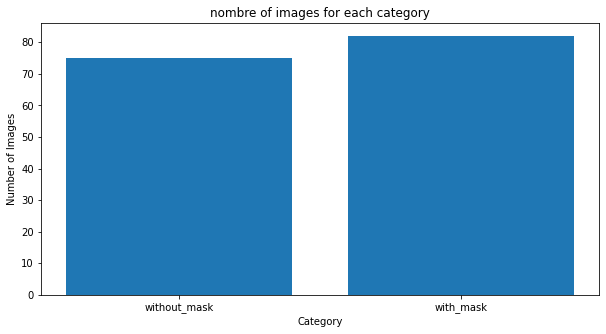

In [5]:
#count nombre of images per categories in the train data
nbOfSimplesPerCategory=[]
for i in listCategories:
    nbOfSimplesPerCategory.append((np.where(y_train == i)[0].size))

#show images distribution in our data train
plt.figure(figsize=(10,5))
plt.bar(listCategories,nbOfSimplesPerCategory )
plt.title("nombre of images for each category")
plt.xlabel("Category")
plt.ylabel("Number of Images")
plt.show

In [6]:
label_encoder = LabelEncoder()
def preProcessing(X_train,X_test,y_train,y_test):
    #we can here use onehot coding or greyscale or any preprocessing 
    X_train = X_train/255
    X_test = X_test /255
    

    #add depth of one to cnn work properly 
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],X_test.shape[3])


    #one hot coding for our categories
    
    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
#     label_encoder.inverse_transform(y_test)

    
    y_train = to_categorical(y_train,nbOfCategories)
    y_test = to_categorical(y_test,nbOfCategories)
                
    
    
    return X_train,X_test,y_train,y_test

In [7]:
#prepoexessing the data
X_train,X_test,y_train,y_test = preProcessing(X_train,X_test,y_train,y_test)

In [8]:
y_train.shape

(157, 2)

## 4 Model Train
So in the section we will  make experiments to find the better set of parameter for your model.
we will start asking the right question : 
- How can you get better performance from your deep learning model?
- How can I improve accuracy?
- What can I do if my neural network performs poorly?\


so in this section we will  try to answer this questions by :

- Improve Performance With Data.
- Improve Performance With Algorithm Parameters.

we will use as architecture for our model the **LeNet** architucture by Yann LeCun .
<br> - Firstly because it’s A great idea to start with a good architucture which it is become the
standard for this kind of problem .Secondly because it is one of the simplest architectures.
<br> - second because it is one of the simplest architectures. 

In [9]:
#model settings 
batchSizeVal=32
epochsVal=30 
stepsPerEpochVal=len(X_train)//batchSizeVal
validation_steps = len(X_test)//batchSizeVal

In [10]:
noOfFilters = 32 
sizeOfFilter1=(5,5)
sizeOfFilter2 =(3,3)
sizeOfPool =(2,2)
noOfNode=64

In [11]:
plotNb= 0
def plotHistory(history,title):
    global plotNb
    plotNb += 1 
    fig1 = plt.figure(1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['training','validation'])
    plt.title('Loss'+title)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    fig1.savefig('plots/'+title+str(plotNb)+'.png', dpi=300)
    
    plotNb += 1
    fig2 = plt.figure(2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['training','validation'])
    plt.title('Accuracy'+title)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    fig2.savefig('plots/'+title+str(plotNb)+'.png', dpi=300)
    
    plt.show()


In [12]:
#this model is based in lenet model
def myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode):

    model =Sequential()
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters, sizeOfFilter1, activation='relu', input_shape=(imageWidth,imageHeight,3)))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add Flatten Layer        
    model.add(Flatten())
    
#     #add dropout layer
#     model.add(Dropout(0.5)) 
    
    #add Dense layer
    model.add(Dense(500, activation='relu'))
    model.add(Dense(nbOfCategories, activation='softmax'))
    
    #compile the model
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

C:\Users\autre\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
history = model.fit(X_train, y_train, epochs=epochsVal,validation_data=(X_test, y_test), batch_size=batchSizeVal)

Epoch 1/30
5/5 [==============================] - 1s 143ms/step - loss: 0.9816 - accuracy: 0.5159 - val_loss: 0.6737 - val_accuracy: 0.6000
Epoch 2/30
5/5 [==============================] - 0s 100ms/step - loss: 0.6755 - accuracy: 0.6178 - val_loss: 0.6133 - val_accuracy: 0.9000
Epoch 3/30
5/5 [==============================] - 0s 101ms/step - loss: 0.5509 - accuracy: 0.7771 - val_loss: 0.4362 - val_accuracy: 0.8750
Epoch 4/30
5/5 [==============================] - 0s 100ms/step - loss: 0.3827 - accuracy: 0.8535 - val_loss: 0.2661 - val_accuracy: 0.9000
Epoch 5/30
5/5 [==============================] - 0s 99ms/step - loss: 0.2739 - accuracy: 0.8790 - val_loss: 0.2256 - val_accuracy: 0.9000
Epoch 6/30
5/5 [==============================] - 1s 104ms/step - loss: 0.1817 - accuracy: 0.9363 - val_loss: 0.3129 - val_accuracy: 0.9250
Epoch 7/30
5/5 [==============================] - 0s 101ms/step - loss: 0.2033 - accuracy: 0.9172 - val_loss: 0.1786 - val_accuracy: 0.9250
Epoch 8/30
5/5 [=====

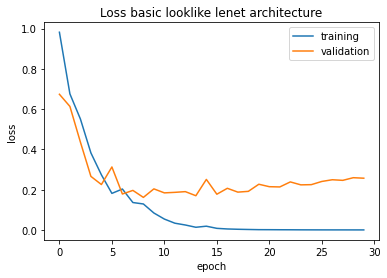

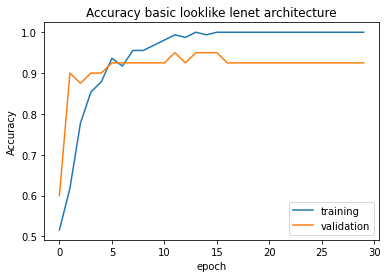

2/2 [==============================] - 0s 10ms/step - loss: 0.2571 - accuracy: 0.9250


0.925000011920929

In [15]:
plotHistory(history," basic looklike lenet architecture")
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

After we run our model with the basic parameter of our initial version, we got a very
high accuracy on our training data-set and we tested our model in our test data-set we
got only 92% but with a loss equal to 0.25 which is a high value .
so this is an example of underfitting because in training set it tends to do so good
(0.01) but on test set it is having only 0.25 lost so most likely there is an underfitting
happening


### 1- Improve Performance With Data


so to skip the underfitting we will try to reuse the old model with two changes :
- supplying data augmentations to our model as our first layer to produce new samples
- adding a dropout layer to drop randomly in each pass à 20% of neurons to have better
generalization

We’ll explore how data augmentation can reduce overfitting and increase the ability of
our model to generalize via two experiments.
To accomplish this goal we will “replace” the training data with randomly transformed,
augmented data. 

**Data augmentations** on images would include transformations like :
• Flipping the image either horizontally or vertically
• Rotation the image
Master InformatiqueRapport - ImageAnnotator and Face Mask recognition 64 Build and optimize our model
• Zooming in and out on the image
• Cropping the image
• Varying the color on the image


In [16]:
#generate other images from our dataset
dataGenerator =ImageDataGenerator(zoom_range=0.15,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.15,
                                  horizontal_flip=True,
                                  rotation_range=20,
                                  fill_mode="nearest")

In [17]:
noOfFilters = 32 
sizeOfFilter1=(5,5)
sizeOfFilter2 =(3,3)
sizeOfPool =(2,2)
noOfNode=500

model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
print(model.summary()) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 128)       

In [18]:
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)

Epoch 1/30


C:\Users\autre\AppData\Local\Temp/ipykernel_15392/3738368180.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGenerator.flow(X_train,y_train,


4/4 [==============================] - 1s 161ms/step - loss: 0.8732 - accuracy: 0.5781 - val_loss: 0.7219 - val_accuracy: 0.4000
Epoch 2/30
4/4 [==============================] - 0s 119ms/step - loss: 0.6785 - accuracy: 0.5040 - val_loss: 0.7063 - val_accuracy: 0.4000
Epoch 3/30
4/4 [==============================] - 0s 113ms/step - loss: 0.6304 - accuracy: 0.5360 - val_loss: 0.6254 - val_accuracy: 0.5750
Epoch 4/30
4/4 [==============================] - 0s 120ms/step - loss: 0.5504 - accuracy: 0.7266 - val_loss: 0.4988 - val_accuracy: 0.8250
Epoch 5/30
4/4 [==============================] - 0s 120ms/step - loss: 0.3895 - accuracy: 0.8560 - val_loss: 0.2969 - val_accuracy: 0.8750
Epoch 6/30
4/4 [==============================] - 0s 115ms/step - loss: 0.3962 - accuracy: 0.8240 - val_loss: 0.3281 - val_accuracy: 0.8250
Epoch 7/30
4/4 [==============================] - 0s 115ms/step - loss: 0.3234 - accuracy: 0.8672 - val_loss: 0.3666 - val_accuracy: 0.7750
Epoch 8/30
4/4 [===============

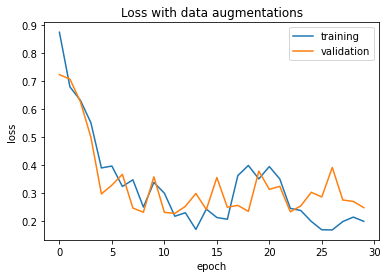

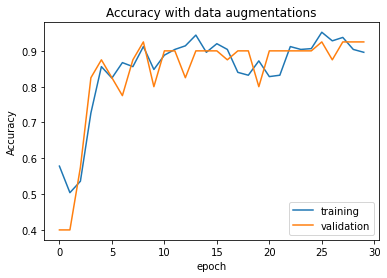

2/2 [==============================] - 0s 10ms/step - loss: 0.2480 - accuracy: 0.9250


0.925000011920929

In [19]:
plotHistory(history," with data augmentations")
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

After we run the model, we got a new val-loss that is accurate with the loss of training
data-set.
but we got a accuracy value that is slightly worse than the previous version of our model
( due to the variations in data caused by the random transforms)

### Regularizations
Dropout is also a great approach to curb overfitting of the training data. So we have
tested different values of the Dropout
We can see that for this problem and for the chosen network configuration that using
dropout in the hidden layers did not lift performance.
It is possible that additional training epochs are required or that further tuning is
required to the learning rate.

In [20]:
#this model is based in lenet model
def myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode):

    model =Sequential()
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters, sizeOfFilter1, activation='relu', input_shape=(imageWidth,imageHeight,3)))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*2, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add conv and polling layers
    model.add(Conv2D(noOfFilters*4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    
    #add Flatten Layer        
    model.add(Flatten())
    
    #add dropout layer
    model.add(Dropout(0.2)) 
    
    #add Dense layer
    model.add(Dense(500, activation='relu'))
    model.add(Dense(nbOfCategories, activation='softmax'))
    
    #compile the model
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)

In [22]:
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)



Epoch 1/30


C:\Users\autre\AppData\Local\Temp/ipykernel_15392/3886179765.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGenerator.flow(X_train,y_train,


4/4 [==============================] - 1s 164ms/step - loss: 0.9682 - accuracy: 0.5280 - val_loss: 0.6668 - val_accuracy: 0.6000
Epoch 2/30
4/4 [==============================] - 0s 119ms/step - loss: 0.7064 - accuracy: 0.4609 - val_loss: 0.6661 - val_accuracy: 0.6000
Epoch 3/30
4/4 [==============================] - 0s 116ms/step - loss: 0.6670 - accuracy: 0.6560 - val_loss: 0.6303 - val_accuracy: 0.7500
Epoch 4/30
4/4 [==============================] - 0s 119ms/step - loss: 0.5708 - accuracy: 0.7344 - val_loss: 0.7277 - val_accuracy: 0.4750
Epoch 5/30
4/4 [==============================] - 0s 118ms/step - loss: 0.5482 - accuracy: 0.7120 - val_loss: 0.5637 - val_accuracy: 0.6500
Epoch 6/30
4/4 [==============================] - 0s 118ms/step - loss: 0.4378 - accuracy: 0.8160 - val_loss: 0.3739 - val_accuracy: 0.9000
Epoch 7/30
4/4 [==============================] - 0s 118ms/step - loss: 0.3583 - accuracy: 0.8560 - val_loss: 0.2658 - val_accuracy: 0.8750
Epoch 8/30
4/4 [===============

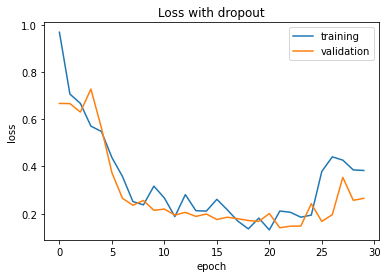

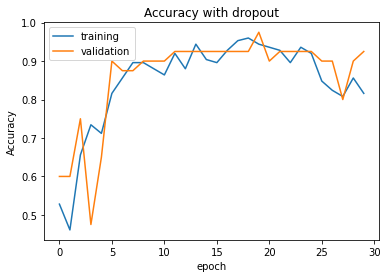

2/2 [==============================] - 0s 10ms/step - loss: 0.2650 - accuracy: 0.9250


0.925000011920929

In [23]:
plotHistory(history," with dropout")
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

We can see that for this problem and for the chosen network configuration that using
dropout in the hidden layers did not lift performance.
It is possible that additional training epochs are required or that further tuning is
required to the learning rate.

## improve performance with algorithm parameters

### Numbre of Epochs 

In this section we will experiment large number (500) of epochs and see their effect in the
global learning curve .

Epoch 1/500


C:\Users\autre\AppData\Local\Temp/ipykernel_15392/2876616725.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGenerator.flow(X_train,y_train,


4/4 [==============================] - 1s 164ms/step - loss: 0.7546 - accuracy: 0.5520 - val_loss: 0.6880 - val_accuracy: 0.6000
Epoch 2/500
4/4 [==============================] - 0s 111ms/step - loss: 0.7102 - accuracy: 0.5360 - val_loss: 0.6830 - val_accuracy: 0.7500
Epoch 3/500
4/4 [==============================] - 0s 118ms/step - loss: 0.6547 - accuracy: 0.7578 - val_loss: 0.5982 - val_accuracy: 0.7000
Epoch 4/500
4/4 [==============================] - 0s 120ms/step - loss: 0.5011 - accuracy: 0.8080 - val_loss: 0.4578 - val_accuracy: 0.8000
Epoch 5/500
4/4 [==============================] - 0s 115ms/step - loss: 0.4371 - accuracy: 0.7920 - val_loss: 0.4838 - val_accuracy: 0.7500
Epoch 6/500
4/4 [==============================] - 0s 121ms/step - loss: 0.4162 - accuracy: 0.8240 - val_loss: 0.6212 - val_accuracy: 0.6750
Epoch 7/500
4/4 [==============================] - 0s 113ms/step - loss: 0.4141 - accuracy: 0.8080 - val_loss: 0.5266 - val_accuracy: 0.7500
Epoch 8/500
4/4 [========

Epoch 59/500
4/4 [==============================] - 0s 112ms/step - loss: 0.0655 - accuracy: 0.9680 - val_loss: 0.0496 - val_accuracy: 0.9500
Epoch 60/500
4/4 [==============================] - 0s 119ms/step - loss: 0.1328 - accuracy: 0.9520 - val_loss: 0.0628 - val_accuracy: 0.9750
Epoch 61/500
4/4 [==============================] - 0s 114ms/step - loss: 0.1726 - accuracy: 0.9600 - val_loss: 0.0411 - val_accuracy: 1.0000
Epoch 62/500
4/4 [==============================] - 0s 118ms/step - loss: 0.1071 - accuracy: 0.9520 - val_loss: 0.1537 - val_accuracy: 0.9500
Epoch 63/500
4/4 [==============================] - 0s 118ms/step - loss: 0.1206 - accuracy: 0.9520 - val_loss: 0.3144 - val_accuracy: 0.9250
Epoch 64/500
4/4 [==============================] - 0s 118ms/step - loss: 0.1805 - accuracy: 0.9200 - val_loss: 0.1386 - val_accuracy: 0.9500
Epoch 65/500
4/4 [==============================] - 0s 115ms/step - loss: 0.0963 - accuracy: 0.9760 - val_loss: 0.1090 - val_accuracy: 0.9500
Epoch 

4/4 [==============================] - 0s 112ms/step - loss: 0.0594 - accuracy: 0.9844 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 174/500
4/4 [==============================] - 0s 113ms/step - loss: 0.0242 - accuracy: 0.9920 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 175/500
4/4 [==============================] - 0s 110ms/step - loss: 0.0752 - accuracy: 0.9760 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 176/500
4/4 [==============================] - 0s 119ms/step - loss: 0.1921 - accuracy: 0.9609 - val_loss: 0.1373 - val_accuracy: 0.9750
Epoch 177/500
4/4 [==============================] - 0s 120ms/step - loss: 0.2271 - accuracy: 0.9297 - val_loss: 0.1030 - val_accuracy: 0.9500
Epoch 178/500
4/4 [==============================] - 0s 114ms/step - loss: 0.1109 - accuracy: 0.9680 - val_loss: 0.0434 - val_accuracy: 1.0000
Epoch 179/500
4/4 [==============================] - 1s 121ms/step - loss: 0.0603 - accuracy: 0.9844 - val_loss: 0.1445 - val_accuracy: 0.9500
Epoch 180/500

4/4 [==============================] - 0s 114ms/step - loss: 0.0432 - accuracy: 0.9920 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 288/500
4/4 [==============================] - 0s 116ms/step - loss: 0.0264 - accuracy: 0.9844 - val_loss: 0.0471 - val_accuracy: 0.9500
Epoch 289/500
4/4 [==============================] - 0s 119ms/step - loss: 0.0336 - accuracy: 0.9840 - val_loss: 0.1052 - val_accuracy: 0.9500
Epoch 290/500
4/4 [==============================] - 0s 114ms/step - loss: 0.0419 - accuracy: 0.9922 - val_loss: 0.1643 - val_accuracy: 0.9500
Epoch 291/500
4/4 [==============================] - 0s 116ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.1092 - val_accuracy: 0.9750
Epoch 292/500
4/4 [==============================] - 0s 111ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1323 - val_accuracy: 0.9500
Epoch 293/500
4/4 [==============================] - 0s 112ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.1370 - val_accuracy: 0.9750
Epoch 294/500

4/4 [==============================] - 0s 112ms/step - loss: 9.0808e-04 - accuracy: 1.0000 - val_loss: 0.0785 - val_accuracy: 0.9500
Epoch 402/500
4/4 [==============================] - 0s 117ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0805 - val_accuracy: 0.9500
Epoch 403/500
4/4 [==============================] - 0s 113ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0851 - val_accuracy: 0.9500
Epoch 404/500
4/4 [==============================] - 0s 118ms/step - loss: 0.0125 - accuracy: 0.9920 - val_loss: 0.0458 - val_accuracy: 0.9750
Epoch 405/500
4/4 [==============================] - 0s 116ms/step - loss: 4.3303e-04 - accuracy: 1.0000 - val_loss: 0.0336 - val_accuracy: 0.9750
Epoch 406/500
4/4 [==============================] - 0s 115ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0311 - val_accuracy: 0.9750
Epoch 407/500
4/4 [==============================] - 0s 114ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0678 - val_accuracy: 0.9500
Epoch

4/4 [==============================] - 0s 114ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0111 - val_accuracy: 1.0000
Epoch 459/500
4/4 [==============================] - 0s 116ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0287 - val_accuracy: 0.9750
Epoch 460/500
4/4 [==============================] - 0s 119ms/step - loss: 6.8490e-04 - accuracy: 1.0000 - val_loss: 0.0645 - val_accuracy: 0.9750
Epoch 461/500
4/4 [==============================] - 0s 115ms/step - loss: 8.1837e-04 - accuracy: 1.0000 - val_loss: 0.1098 - val_accuracy: 0.9500
Epoch 462/500
4/4 [==============================] - 0s 112ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 0.9750
Epoch 463/500
4/4 [==============================] - 0s 113ms/step - loss: 0.0071 - accuracy: 0.9920 - val_loss: 0.0058 - val_accuracy: 1.0000
Epoch 464/500
4/4 [==============================] - 0s 116ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch

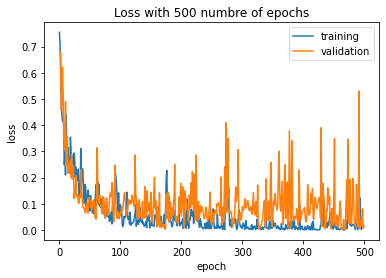

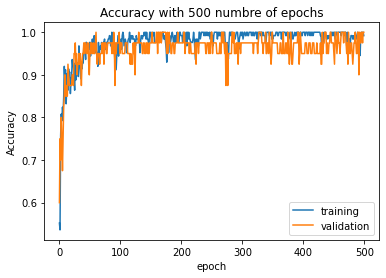

--------------------------------------------
2/2 [==============================] - 0s 11ms/step - loss: 0.0153 - accuracy: 1.0000
test_acc :  1.0
--------------------------------------------


In [24]:
epochsVal = 500

model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)


plotHistory(history," with 500 numbre of epochs")
print('--------------------------------------------')
test_loss, test_acc = model.evaluate(X_test, y_test)
print ('test_acc : ',test_acc)
print('--------------------------------------------')

The figure above shows the effect of the number of epochs on the loss rate, starting
from 100 epochs the lost rate in the training set was almost constant, however, it varies
a lot with the validation set ranging from , approximately 0.02 to 0.5.
These plots can help to diagnose whether the model has over learned, under learned,
or is suitably fit to the training data-set.
in our case we see that start to decrease until it reach 100 - 150 and after it stared to
increase again so we can see after a 150 epochs our model well start over learning .

In [25]:
epochsVal = 100

### Size of Batch  

we will try different size of batch : 
- Try batch size equal to training data size, memory depending (batch learning).
- Try a batch size of one (online learning).
- Try a grid search of different mini-batch sizes (8, 16, 32, …).
- Try training for a few epochs and for a heck of a lot of epochs.

In [26]:
def SearchOptimalModel( batchSizeVal,noOfNode) : 
    stepsPerEpochVal=len(X_train)//batchSizeVal
    validation_steps = len(X_test)//batchSizeVal
    
    model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
    history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    return history ,test_acc

In [28]:
    
listBatchSize=[1,8,16,32,64,128]
listHistory=[]
listTestAcc=[]
for batchSizeVal  in listBatchSize :
    h,acc =SearchOptimalModel( batchSizeVal,500)
    listHistory.append(h)
    listTestAcc.append(acc)

C:\Users\autre\AppData\Local\Temp/ipykernel_15392/1308937236.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGenerator.flow(X_train,y_train,


Epoch 1/100
157/157 [==============================] - 2s 12ms/step - loss: 0.8371 - accuracy: 0.5732 - val_loss: 0.6874 - val_accuracy: 0.6000
Epoch 2/100
157/157 [==============================] - 2s 11ms/step - loss: 0.6946 - accuracy: 0.4713 - val_loss: 0.6832 - val_accuracy: 0.8000
Epoch 3/100
157/157 [==============================] - 2s 11ms/step - loss: 0.6385 - accuracy: 0.6369 - val_loss: 0.5998 - val_accuracy: 0.6500
Epoch 4/100
157/157 [==============================] - 2s 11ms/step - loss: 0.6265 - accuracy: 0.6752 - val_loss: 0.6251 - val_accuracy: 0.8000
Epoch 5/100
157/157 [==============================] - 2s 11ms/step - loss: 0.7040 - accuracy: 0.6624 - val_loss: 0.6724 - val_accuracy: 0.7500
Epoch 6/100
157/157 [==============================] - 2s 11ms/step - loss: 0.6297 - accuracy: 0.6242 - val_loss: 0.7916 - val_accuracy: 0.6250
Epoch 7/100
157/157 [==============================] - 2s 11ms/step - loss: 0.7437 - accuracy: 0.6051 - val_loss: 0.6946 - val_accuracy:

19/19 [==============================] - 1s 34ms/step - loss: 0.2050 - accuracy: 0.9329 - val_loss: 0.3851 - val_accuracy: 0.8750
Epoch 14/100
19/19 [==============================] - 1s 33ms/step - loss: 0.2552 - accuracy: 0.9060 - val_loss: 0.2232 - val_accuracy: 0.9000
Epoch 15/100
19/19 [==============================] - 1s 34ms/step - loss: 0.2146 - accuracy: 0.9329 - val_loss: 0.2375 - val_accuracy: 0.9000
Epoch 16/100
19/19 [==============================] - 1s 33ms/step - loss: 0.2595 - accuracy: 0.9262 - val_loss: 0.2961 - val_accuracy: 0.9000
Epoch 17/100
19/19 [==============================] - 1s 34ms/step - loss: 0.2349 - accuracy: 0.9128 - val_loss: 0.2114 - val_accuracy: 0.9000
Epoch 18/100
19/19 [==============================] - 1s 34ms/step - loss: 0.2102 - accuracy: 0.9329 - val_loss: 0.1992 - val_accuracy: 0.9000
Epoch 19/100
19/19 [==============================] - 1s 33ms/step - loss: 0.1969 - accuracy: 0.9262 - val_loss: 0.2607 - val_accuracy: 0.8750
Epoch 20/100

9/9 [==============================] - 1s 58ms/step - loss: 0.1397 - accuracy: 0.9645 - val_loss: 0.1493 - val_accuracy: 0.9000
Epoch 28/100
9/9 [==============================] - 1s 57ms/step - loss: 0.1304 - accuracy: 0.9787 - val_loss: 0.2707 - val_accuracy: 0.9000
Epoch 29/100
9/9 [==============================] - 1s 60ms/step - loss: 0.1693 - accuracy: 0.9306 - val_loss: 0.3622 - val_accuracy: 0.9000
Epoch 30/100
9/9 [==============================] - 1s 59ms/step - loss: 0.1176 - accuracy: 0.9362 - val_loss: 0.0944 - val_accuracy: 0.9500
Epoch 31/100
9/9 [==============================] - 1s 58ms/step - loss: 0.1233 - accuracy: 0.9433 - val_loss: 0.1070 - val_accuracy: 0.9250
Epoch 32/100
9/9 [==============================] - 1s 58ms/step - loss: 0.1964 - accuracy: 0.9574 - val_loss: 0.1918 - val_accuracy: 0.9250
Epoch 33/100
9/9 [==============================] - 1s 60ms/step - loss: 0.2590 - accuracy: 0.9078 - val_loss: 0.0967 - val_accuracy: 0.9250
Epoch 34/100
9/9 [========

4/4 [==============================] - 1s 143ms/step - loss: 0.1179 - accuracy: 0.9760 - val_loss: 0.2090 - val_accuracy: 0.9250
Epoch 43/100
4/4 [==============================] - 0s 115ms/step - loss: 0.0977 - accuracy: 0.9760 - val_loss: 0.1847 - val_accuracy: 0.9500
Epoch 44/100
4/4 [==============================] - 0s 115ms/step - loss: 0.1168 - accuracy: 0.9440 - val_loss: 0.2521 - val_accuracy: 0.9250
Epoch 45/100
4/4 [==============================] - 1s 140ms/step - loss: 0.1606 - accuracy: 0.9440 - val_loss: 0.1364 - val_accuracy: 0.9250
Epoch 46/100
4/4 [==============================] - 1s 128ms/step - loss: 0.1314 - accuracy: 0.9600 - val_loss: 0.2615 - val_accuracy: 0.9250
Epoch 47/100
4/4 [==============================] - 1s 133ms/step - loss: 0.1448 - accuracy: 0.9520 - val_loss: 0.1285 - val_accuracy: 0.9250
Epoch 48/100
4/4 [==============================] - 0s 117ms/step - loss: 0.0958 - accuracy: 0.9609 - val_loss: 0.2653 - val_accuracy: 0.9250
Epoch 49/100
4/4 [=

Epoch 100/100
2/2 [==============================] - 0s 8ms/step - loss: 0.2298 - accuracy: 0.9250
Epoch 1/100
2/2 [==============================] - 1s 399ms/step - loss: 0.8442 - accuracy: 0.4516 - val_loss: 0.6594 - val_accuracy: 0.6000
Epoch 2/100
2/2 [==============================] - 0s 160ms/step - loss: 0.7152 - accuracy: 0.6559 - val_loss: 0.6672 - val_accuracy: 0.6000
Epoch 3/100
2/2 [==============================] - 0s 155ms/step - loss: 0.7152 - accuracy: 0.4301 - val_loss: 0.6729 - val_accuracy: 0.9250
Epoch 4/100
2/2 [==============================] - 1s 266ms/step - loss: 0.6614 - accuracy: 0.6953 - val_loss: 0.7004 - val_accuracy: 0.4000
Epoch 5/100
2/2 [==============================] - 0s 255ms/step - loss: 0.6444 - accuracy: 0.5376 - val_loss: 0.7533 - val_accuracy: 0.4000
Epoch 6/100
2/2 [==============================] - 0s 140ms/step - loss: 0.6571 - accuracy: 0.4946 - val_loss: 0.6600 - val_accuracy: 0.4500
Epoch 7/100
2/2 [==============================] - 0s 1

1/1 [==============================] - 0s 202ms/step - loss: 0.2735 - accuracy: 0.8276 - val_loss: 0.4998 - val_accuracy: 0.7750
Epoch 15/100
1/1 [==============================] - 0s 194ms/step - loss: 0.3335 - accuracy: 0.8966 - val_loss: 0.4113 - val_accuracy: 0.8500
Epoch 16/100
1/1 [==============================] - 1s 516ms/step - loss: 0.3194 - accuracy: 0.8828 - val_loss: 0.3819 - val_accuracy: 0.8250
Epoch 17/100
1/1 [==============================] - 0s 195ms/step - loss: 0.2196 - accuracy: 0.8276 - val_loss: 0.4301 - val_accuracy: 0.8000
Epoch 18/100
1/1 [==============================] - 1s 513ms/step - loss: 0.4089 - accuracy: 0.8125 - val_loss: 0.3720 - val_accuracy: 0.8750
Epoch 19/100
1/1 [==============================] - 1s 534ms/step - loss: 0.3284 - accuracy: 0.8828 - val_loss: 0.4865 - val_accuracy: 0.7750
Epoch 20/100
1/1 [==============================] - 0s 188ms/step - loss: 0.2645 - accuracy: 0.8966 - val_loss: 0.2949 - val_accuracy: 0.8750
Epoch 21/100
1/1 [=

Epoch 72/100
1/1 [==============================] - 1s 514ms/step - loss: 0.1798 - accuracy: 0.9219 - val_loss: 0.1854 - val_accuracy: 0.9000
Epoch 73/100
1/1 [==============================] - 1s 504ms/step - loss: 0.1728 - accuracy: 0.9297 - val_loss: 0.1801 - val_accuracy: 0.9000
Epoch 74/100
1/1 [==============================] - 1s 543ms/step - loss: 0.1585 - accuracy: 0.9453 - val_loss: 0.1694 - val_accuracy: 0.9000
Epoch 75/100
1/1 [==============================] - 0s 198ms/step - loss: 0.1741 - accuracy: 0.9655 - val_loss: 0.1469 - val_accuracy: 0.9500
Epoch 76/100
1/1 [==============================] - 1s 514ms/step - loss: 0.1473 - accuracy: 0.9531 - val_loss: 0.1448 - val_accuracy: 0.9500
Epoch 77/100
1/1 [==============================] - 1s 509ms/step - loss: 0.1923 - accuracy: 0.9375 - val_loss: 0.1395 - val_accuracy: 0.9500
Epoch 78/100
1/1 [==============================] - 0s 197ms/step - loss: 0.2080 - accuracy: 0.9310 - val_loss: 0.1963 - val_accuracy: 0.9000
Epoch 

In [29]:
for i in range(len(listHistory)):
    #plotHistory(listHistory[i])
    print('--------------------------------------------')
    print('for batch size  = ',listBatchSize[i] )
    print ('test_acc : ',listTestAcc[i])
    print('--------------------------------------------')
    
    

--------------------------------------------
for batch size  =  1
test_acc :  0.949999988079071
--------------------------------------------
--------------------------------------------
for batch size  =  8
test_acc :  0.949999988079071
--------------------------------------------
--------------------------------------------
for batch size  =  16
test_acc :  0.9750000238418579
--------------------------------------------
--------------------------------------------
for batch size  =  32
test_acc :  0.925000011920929
--------------------------------------------
--------------------------------------------
for batch size  =  64
test_acc :  0.9750000238418579
--------------------------------------------
--------------------------------------------
for batch size  =  128
test_acc :  0.8999999761581421
--------------------------------------------


So finally we decided to use 16 as the batch size as it gave the best result in terms of
accuracy.<br>
• A batch size equal to the training data size, depending on the memory (batch
learning). <br>
• A batch size of one (online learning).<br>
• Tried a grid search of different mini-batch sizes (8, 16, 32, . . . ).<br>
• Try training for a few epochs and for a lot of epochs.

In [ ]:
batchSizeVal = 16

### Numbre of neurons 

In [30]:
listNbNeurons = [32,64,128,500]

listTestAcc=[]
listHistory=[]
for noOfNode  in listNbNeurons :
    h,acc =SearchOptimalModel(batchSizeVal ,noOfNode)
    listHistory.append(h)
    listTestAcc.append(acc)


C:\Users\autre\AppData\Local\Temp/ipykernel_15392/1308937236.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGenerator.flow(X_train,y_train,


Epoch 1/100
1/1 [==============================] - 1s 785ms/step - loss: 0.6940 - accuracy: 0.4483 - val_loss: 0.6657 - val_accuracy: 0.6750
Epoch 2/100
1/1 [==============================] - 1s 521ms/step - loss: 0.6584 - accuracy: 0.7109 - val_loss: 0.7947 - val_accuracy: 0.4000
Epoch 3/100
1/1 [==============================] - 0s 187ms/step - loss: 0.6876 - accuracy: 0.5517 - val_loss: 0.9054 - val_accuracy: 0.6000
Epoch 4/100
1/1 [==============================] - 0s 190ms/step - loss: 0.8535 - accuracy: 0.5517 - val_loss: 0.6271 - val_accuracy: 0.6250
Epoch 5/100
1/1 [==============================] - 1s 509ms/step - loss: 0.7051 - accuracy: 0.4453 - val_loss: 0.7293 - val_accuracy: 0.4000
Epoch 6/100
1/1 [==============================] - 1s 505ms/step - loss: 0.6206 - accuracy: 0.5469 - val_loss: 0.8695 - val_accuracy: 0.4000
Epoch 7/100
1/1 [==============================] - 1s 539ms/step - loss: 0.6596 - accuracy: 0.5703 - val_loss: 0.8061 - val_accuracy: 0.4000
Epoch 8/100
1

Epoch 59/100
1/1 [==============================] - 0s 200ms/step - loss: 0.1193 - accuracy: 0.9655 - val_loss: 0.1166 - val_accuracy: 0.9500
Epoch 60/100
1/1 [==============================] - 1s 530ms/step - loss: 0.2365 - accuracy: 0.9062 - val_loss: 0.1483 - val_accuracy: 0.9000
Epoch 61/100
1/1 [==============================] - 0s 193ms/step - loss: 0.1544 - accuracy: 0.9310 - val_loss: 0.1852 - val_accuracy: 0.8750
Epoch 62/100
1/1 [==============================] - 1s 524ms/step - loss: 0.1752 - accuracy: 0.9375 - val_loss: 0.1513 - val_accuracy: 0.9000
Epoch 63/100
1/1 [==============================] - 0s 193ms/step - loss: 0.2653 - accuracy: 0.8966 - val_loss: 0.1321 - val_accuracy: 0.9500
Epoch 64/100
1/1 [==============================] - 1s 518ms/step - loss: 0.2100 - accuracy: 0.9062 - val_loss: 0.1367 - val_accuracy: 0.9500
Epoch 65/100
1/1 [==============================] - 0s 184ms/step - loss: 0.2298 - accuracy: 0.8966 - val_loss: 0.1377 - val_accuracy: 0.9750
Epoch 

Epoch 74/100
1/1 [==============================] - 1s 535ms/step - loss: 0.1302 - accuracy: 0.9531 - val_loss: 0.2308 - val_accuracy: 0.9250
Epoch 75/100
1/1 [==============================] - 1s 507ms/step - loss: 0.1333 - accuracy: 0.9453 - val_loss: 0.2282 - val_accuracy: 0.9250
Epoch 76/100
1/1 [==============================] - 0s 182ms/step - loss: 0.1442 - accuracy: 0.9310 - val_loss: 0.2417 - val_accuracy: 0.9250
Epoch 77/100
1/1 [==============================] - 0s 185ms/step - loss: 0.2203 - accuracy: 0.9310 - val_loss: 0.2185 - val_accuracy: 0.9250
Epoch 78/100
1/1 [==============================] - 0s 192ms/step - loss: 0.1351 - accuracy: 0.9655 - val_loss: 0.2113 - val_accuracy: 0.9250
Epoch 79/100
1/1 [==============================] - 1s 500ms/step - loss: 0.3078 - accuracy: 0.8984 - val_loss: 0.2439 - val_accuracy: 0.9250
Epoch 80/100
1/1 [==============================] - 1s 595ms/step - loss: 0.1393 - accuracy: 0.9531 - val_loss: 0.3198 - val_accuracy: 0.9000
Epoch 

Epoch 89/100
1/1 [==============================] - 0s 183ms/step - loss: 0.1280 - accuracy: 0.9310 - val_loss: 0.2614 - val_accuracy: 0.9000
Epoch 90/100
1/1 [==============================] - 0s 500ms/step - loss: 0.1586 - accuracy: 0.9609 - val_loss: 0.1897 - val_accuracy: 0.9250
Epoch 91/100
1/1 [==============================] - 0s 180ms/step - loss: 0.3595 - accuracy: 0.8966 - val_loss: 0.1293 - val_accuracy: 0.9500
Epoch 92/100
1/1 [==============================] - 0s 190ms/step - loss: 0.0583 - accuracy: 0.9655 - val_loss: 0.1506 - val_accuracy: 0.9250
Epoch 93/100
1/1 [==============================] - 1s 503ms/step - loss: 0.3039 - accuracy: 0.8906 - val_loss: 0.1284 - val_accuracy: 0.9250
Epoch 94/100
1/1 [==============================] - 0s 184ms/step - loss: 0.2091 - accuracy: 0.8966 - val_loss: 0.1257 - val_accuracy: 0.9750
Epoch 95/100
1/1 [==============================] - 0s 181ms/step - loss: 0.1757 - accuracy: 0.9310 - val_loss: 0.2217 - val_accuracy: 0.9000
Epoch 

In [31]:
for i in range(len(listNbNeurons)):
    print('--------------------------------------------')
    print('for Number of Neurons   = ',listNbNeurons[i] )
    print ('test_acc : ',listTestAcc[i])
    print('--------------------------------------------')

--------------------------------------------
for Number of Neurons   =  32
test_acc :  0.925000011920929
--------------------------------------------
--------------------------------------------
for Number of Neurons   =  64
test_acc :  0.925000011920929
--------------------------------------------
--------------------------------------------
for Number of Neurons   =  128
test_acc :  0.949999988079071
--------------------------------------------
--------------------------------------------
for Number of Neurons   =  500
test_acc :  0.925000011920929
--------------------------------------------


As the figure shows, we decided to use 128 as the number of neurons as it gave the
best result in terms of accuracy

So the optimal parameters for our model are:

In [32]:
noOfNode = 128 
batchSizeVal = 16
epochsVal = 100

In [51]:
model=myModel(noOfFilters,sizeOfFilter1,sizeOfFilter2,sizeOfPool,noOfNode)
history = model.fit_generator(dataGenerator.flow(X_train,y_train,
                                                 batch_size=batchSizeVal),
                                                 steps_per_epoch=stepsPerEpochVal,
                                                validation_data=(X_test, y_test),
                                                epochs=epochsVal,
                                                shuffle=1)
test_loss, test_acc = model.evaluate(X_test, y_test)

C:\Users\autre\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\autre\AppData\Local\Temp/ipykernel_15392/2731775036.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGenerator.flow(X_train,y_train,


Epoch 1/100
4/4 [==============================] - 1s 196ms/step - loss: 0.9464 - accuracy: 0.5391 - val_loss: 0.6792 - val_accuracy: 0.6000
Epoch 2/100
4/4 [==============================] - 1s 143ms/step - loss: 0.6858 - accuracy: 0.6240 - val_loss: 0.6690 - val_accuracy: 0.5750
Epoch 3/100
4/4 [==============================] - 1s 142ms/step - loss: 0.6171 - accuracy: 0.7280 - val_loss: 0.6805 - val_accuracy: 0.4500
Epoch 4/100
4/4 [==============================] - 1s 143ms/step - loss: 0.5124 - accuracy: 0.7188 - val_loss: 0.7213 - val_accuracy: 0.5750
Epoch 5/100
4/4 [==============================] - 1s 142ms/step - loss: 0.4686 - accuracy: 0.7600 - val_loss: 0.4308 - val_accuracy: 0.7500
Epoch 6/100
4/4 [==============================] - 1s 149ms/step - loss: 0.4100 - accuracy: 0.8320 - val_loss: 0.5687 - val_accuracy: 0.7250
Epoch 7/100
4/4 [==============================] - 1s 144ms/step - loss: 0.4223 - accuracy: 0.8160 - val_loss: 0.4033 - val_accuracy: 0.7750
Epoch 8/100
4

Epoch 59/100
4/4 [==============================] - 1s 136ms/step - loss: 0.1319 - accuracy: 0.9520 - val_loss: 0.1085 - val_accuracy: 0.9500
Epoch 60/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0848 - accuracy: 0.9680 - val_loss: 0.1070 - val_accuracy: 0.9250
Epoch 61/100
4/4 [==============================] - 1s 136ms/step - loss: 0.0986 - accuracy: 0.9760 - val_loss: 0.0568 - val_accuracy: 0.9750
Epoch 62/100
4/4 [==============================] - 1s 140ms/step - loss: 0.0907 - accuracy: 0.9760 - val_loss: 0.1321 - val_accuracy: 0.9250
Epoch 63/100
4/4 [==============================] - 1s 148ms/step - loss: 0.0627 - accuracy: 0.9680 - val_loss: 0.0850 - val_accuracy: 0.9750
Epoch 64/100
4/4 [==============================] - 1s 138ms/step - loss: 0.1163 - accuracy: 0.9453 - val_loss: 0.1223 - val_accuracy: 0.9500
Epoch 65/100
4/4 [==============================] - 1s 143ms/step - loss: 0.0924 - accuracy: 0.9680 - val_loss: 0.0791 - val_accuracy: 0.9750
Epoch 

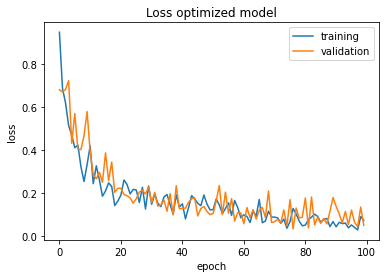

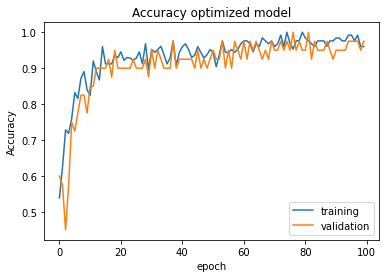

2/2 [==============================] - 0s 11ms/step - loss: 0.0495 - accuracy: 0.9750


0.9750000238418579

In [52]:
plotHistory(history," optimized model")
test_loss, test_acc = model.evaluate(X_test, y_test)
test_acc

# save the model

In [93]:
model.save("my_model")
model.save_weights("weights.h5")
np.save('classes.npy', label_encoder.classes_)

NameError: name 'tf' is not defined

# Prediction and test function


In [89]:
def predict(filpath , mode):
    green =  '\033[1;37;42m'
    red =    '\033[1;37;41m'
    import cv2
    import numpy as np
    imageWidth = 64
    imageHeight = 64

    #load model
    from tensorflow import keras
    model = keras.models.load_model('my_model')
    model.load_weights("weights.h5")
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load('classes.npy')
    
    imgOriginal = cv2.imread(filpath)
    img = np.asarray(imgOriginal)
    img = cv2.resize(img, (imageWidth, imageHeight))
    img = img / 255
    img=img.reshape(1,imageWidth,imageWidth,3)

    
    
    
    prediction = model.predict(img)
    if(mode == "category"):
        
        probVal = np.amax(model.predict(img))
        
        category = label_encoder.inverse_transform([int(np.argmax(prediction[0]))])[0] 
        print(category)
        if category == 'without_mask' :
            colortext =(0,0,220)
        else :

            colortext =(0,245,128)
        
        cv2.putText(imgOriginal,str(category) +" "+str(probVal),(0,50),cv2.FONT_HERSHEY_COMPLEX,1,colortext,2)
        
    elif(mode == "probabilites"):
        probabilites = {}
        i = 0
        for probability in prediction[0]:
            probabilites[label_encoder.inverse_transform([int(prediction[0][i])])[0]]=str(round(float("{:.8f}".format(float(probability))), 2) * 100)+'%'
            
            i += 1
        print(probabilites)
    else:
        print("Mode not recognized")


In [92]:
mode = 'probabilites'
predict(r'C:\Users\autre\Desktop\nnl2\dataset\without_mask\image_25.png' ,mode )

{'with_mask': '0.0%', 'without_mask': '100.0%'}


# real time detector


In [100]:
import cv2
import numpy as np
imageWidth = 64
imageHeight = 64

#load model
from tensorflow import keras
model = keras.models.load_model('my_model')
model.load_weights("weights.h5")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('classes.npy')



#run camera
cap = cv2.VideoCapture(0)
cap.set(3,1000)
cap.set(4, 600)

while True:
    sucess, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img, (imageWidth, imageHeight))
    img = img / 255
    img=img.reshape(1,imageWidth,imageWidth,3)
    
    probVal = np.amax(model.predict(img))
    prediction = model.predict(img)
    
    category = label_encoder.inverse_transform([int(np.argmax(prediction[0]))])[0] 
    print(category)
    if category == 'without_mask' :
            colortext =(0,0,220)
    else :

        colortext =(0,245,128)
        
    cv2.putText(imgOriginal,str(category) +" "+str(probVal),(0,50),cv2.FONT_HERSHEY_COMPLEX,1,colortext,2)

    cv2.imshow("processed image", imgOriginal)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

with_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
without_mask
without_mask
without_mask
without_mask
without_mask
with_mask
with_mask
with_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
with_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mas

without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask

without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
without_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
with_mask
without_mask
with_mask
wi